# Transformers HSTU tutorial
This tutorial tells about *Hierarchical Sequential Transduction Unit* *(HSTU)* - self-attention mechanism proposed in paper [Actions Speak Louder than Words: Trillion-Parameter Sequential Transducers
for Generative Recommendations](https://arxiv.org/abs/2402.17152).
RecTools implementation of HSTU is fully compatible with our `fit / recommend` paradigm, requires no special data processing and is widely customizable.

The important part of current tutorial is the fact that **HSTU metrics on public datasets from the original paper were underestimated**. We show the actual metrics in the most common academic leave-one-out setup below.

### Table of Contents

* HSTU architecture
* Rectools implementation of HSTU model
* Results on Movielens datasets
* Ablation study for Relative Attention Bias
* Context-aware recommendations for HSTU model



## HSTU architecture

HSTU is a sequentual transduction architecture challenging recommendation systems problems. We make short overview.

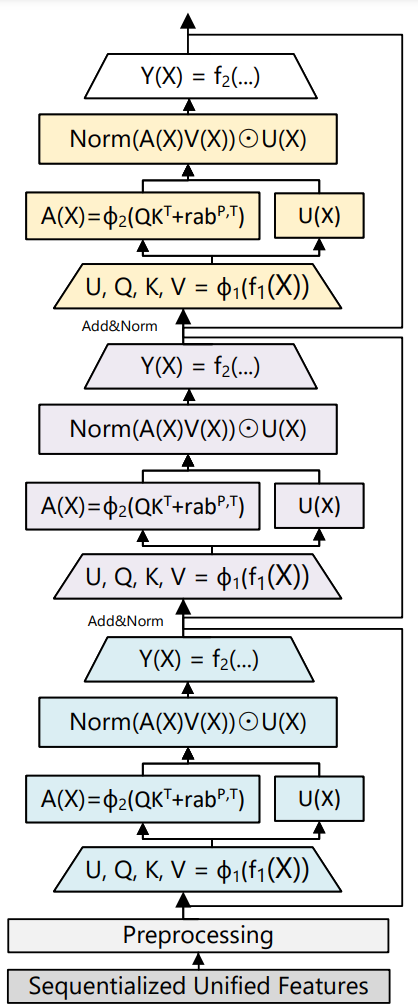

In the simplest case, a "Sequentialized Unified Features" refer to a sequence of user interactions and the training objective of the architecture may follow the standard shifted-sequence approach (paper reports its main results on public datasets using this setup). Meanwhile, other approaches (e.g. Generative Recommender) are also explicitly discussed and provided in the original repository. 

According to paper, HSTU consists of a stack of identical layers connected by residual connections. Each layer contains three sub-layers: Pointwise Projection
(Equation 1), Spatial Aggregation (Equation 2), and Pointwise Transformation (Equation 3)

\begin{equation}
U(X), V(X), Q(X), K(X) = \text{Split}(\phi_1(f_1(X))) \tag{1}
\end{equation}

\begin{equation}
A(X)V(X) = \frac{\phi_2 \left( Q(X)K(X)^T + \text{rab}^{p,t} \right) V(X)}{N} \tag{2}
\end{equation}

\begin{equation}
Y(X) = f_2 \left( \text{Norm}(A(X)V(X)) \odot U(X) \right) \tag{3}
\end{equation}

where $ f_{i} $ is a linear mapping, $\phi$ is the SiLU function, and $\text{rab}^{p,t} $ is the sum of two attention matrices: relative positional attention  and relative time attention. The first important change is the use of elementwise SiLU instead of SoftMax. This approach allows for faster learning in a setting where the set of items is constantly changing. Moreover, the denominator of the softmax normalizes attention, capturing all the previous context of user interactions, and this is not always justified. SiLU changes the absolute value of token-to-token attention. The second change is the weighting of the classic self-attention output by the $U(X)$ matrix, which solves the DLRM problem of feature interaction.


There is an added `rab` (Relative Attention Bias) component added to attention during computation. While position bias utilizes difference in items positions, temporal bias is more complicated. To predict the next item, model uses the actual time of its appearance. This is a simulation of inference with time aware setup, where in addition to the user's history, we would also provide the user query time when preparing recommendations. In this case, the predicted token will be conditioned on that time. In this way, the consistency of the model is maintained between training and testing (or real-world inference). 
Temporal bias utilizes timestamps differences: all possible cross-item differences $a_{i,j}$ are quantized into buckets with logarithmic asymptotics. Each bucket value corresponds to the learnt parameter $w_{i}$ which then forms the matrix $\text{rab}^{t}$. Quantification of the timestamp difference actually breaks down the user's previous history into time microsessions relative to the query generation moment.


\begin{equation}
    a_{i,j} = t_{i+1} - t_j
\end{equation}
\begin{equation}
\text{bucket}(a_{i,j}) =
\left\lfloor \frac{\log(\max(1, |a_{i,j}|))}{0.301} \right\rfloor
\end{equation}

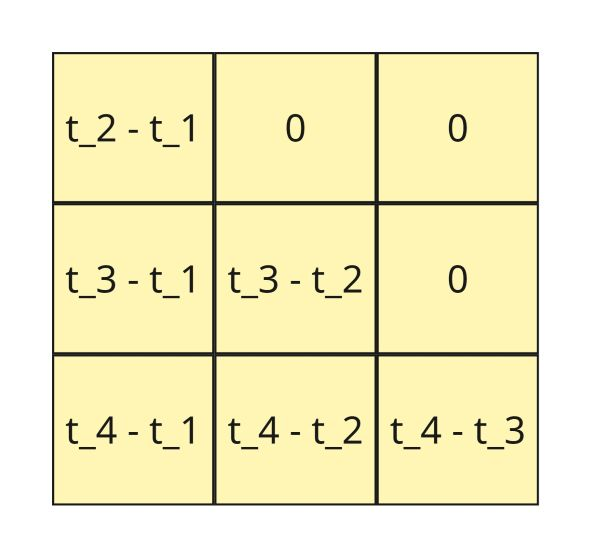

## RecTools implementation of HSTU model

**In order to fully reproduce the architecture** that authors of "Actions..." used for public benchmarks in table 4 of the paper:
1) We use "Shifted Sequence" training objective
2) We don't incorporate actions interleaving
3) Therefore, current RecTools implementation for HSTU is a traditional sequential recommender (like SASRec) which is enhanced with an updated sequential transduction architecture (HSTU).
4) The important point is that unlike simpler architectures, HSTU is capable of context-aware recommendations (where context is formed by the desired timestamp of recommendations for each user).

What's changed (we reassured that each modification still provided the same quality as the original code):
1) Jagged tensors logic was removed
2) Parameters initialization logic was replaced by xavier distribution for consistency with other RecTools models
3) Left padding istead of right for consistency with other RecTools models
4) No Q,K caching option

In [31]:
import os
import warnings

import torch
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import ast
from rectools.dataset import Dataset
from rectools.models import HSTUModel
from rectools import Columns
from scipy import sparse
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
from rectools.model_selection.splitter import Splitter
from rectools.model_selection import LastNSplitter
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
from rectools.metrics import (
    CoveredUsers,
    Serendipity,
    NDCG,
    AvgRecPopularity,
    CatalogCoverage,
    Recall,
    SufficientReco,
)
from rectools.models import  SASRecModel
from rectools.model_selection import  cross_validate
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools.models.nn.transformers.utils import  leave_one_out_mask
import json
from utils import  RecallCallback, BestModelLoadCallback, get_results

In [ ]:
RANDOM_STATE=42
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

## Results on Movielens datasets

In the original repository user interactions were sorted by timestamps without a `stable` sorting option, which means that interactions with the same timestamp could be reordered from their original order. Unfortunately, both ML-1M and ML-20M datasets used in the paper have considerable amount of interactions timestamps collisions. This resulted in multiple consequences:
1. The leave-one-out test that was used to report metrics was not the same as in other papers (we found up to 25% difference in targets) => metrics cannot be directly comparable
2. The order of interactions for each user used for model training differed from order used in other papers => metrics cannot be directly comparable (again)
3. The sorting without `stable` option may easily provide different results on different machines => both the original test and training interactions sequences used by authors of "Actions..." are absolutely unavailable and cannot be reproduced even with the original repository code.

See the reference code:
https://github.com/meta-recsys/generative-recommenders/blob/88512dbd71b053226bc4ef8ec1630e3db53e55e5/generative_recommenders/research/data/preprocessor.py#L267

**The great part about the whole story is that: HSTU metrics recalculated on datasets with stable sorting (which we hope are used mode often) are actually higher then those reported by the authors.**

#### Results on MovieLens-1M
| Method              | HR@10  | NDCG@10 | HR@50  | NDCG@50 | HR@200 | NDCG@200 |
|---------------------|--------|---------|--------|---------|--------|----------|
| HSTU paper          | 0.3097 | 0.1720  | 0.5754 | 0.2307  | 0.7716 | 0.2606   |
| HSTU RecTools       | 0.3226 | 0.1880  | 0.5894 | 0.2471  | 0.7856 | 0.2769   |
| HSTU-large paper    | 0.3294 | 0.1893  | 0.5935 | 0.2481  | 0.7839 | 0.2771   |
| HSTU-large RecTools | 0.3642 | 0.2164  | 0.6194 | 0.2736  | 0.8031 | 0.3015   |



#### Results on MovieLens-20M
| Method              | HR@10  | NDCG@10 | HR@50  | NDCG@50 | HR@200 | NDCG@200 |
|---------------------|--------|---------|--------|---------|--------|----------|
| HSTU paper          | 0.3273 | 0.1895  | 0.5889 | 0.2473  | 0.7952 | 0.2787   |
| HSTU RecTools       | 0.3441 | 0.2066  | 0.6002 | 0.2632  | 0.8008 | 0.2938   |

#### Code for reproduction:

In [33]:
def get_movielens_df(dataset_name: str = "ml-1m") -> pd.DataFrame:
    if dataset_name == "ml-1m":
        ratings = pd.read_csv(
            "ml-1m/ratings.dat",
            sep="::",
            names=["userId", "movieId", "rating", "timestamp"],
            engine="python",
        )
    elif dataset_name == "ml-20m":
        ratings = pd.read_csv("ml-20m/ratings.csv")
    ratings = ratings[ratings["rating"] >= 0]
    ratings.rename(
        columns={
            "userId": Columns.User,
            "movieId": Columns.Item,
            "timestamp": Columns.Datetime,
        },
        inplace=True,
    )
    ratings[Columns.Datetime] = pd.to_datetime(ratings[Columns.Datetime], unit="s")
    ratings[Columns.Weight] = 1
    return ratings

In [34]:
# Prepare trainer function for models

# We use callbacks for calculating recall on validation fold, making model checkpoint based on best recall, early stopping and best model load
# We train for maximum 100 epochs
# This is the most common academic training setup for sequential models

RECALL_K = 10
PATIENCE = 5
DIVERGENCE_TRESHOLD = 0.01
EPOCHS = 100
recall_callback = RecallCallback(k=RECALL_K, progress_bar=True)
# Checkpoints based on best recall
max_recall_ckpt = ModelCheckpoint(
    monitor=f"recall@{RECALL_K}",   # or just pass "val_loss" here,
    mode="max",
    filename="best_recall",
)
early_stopping_recall = EarlyStopping(
    monitor=f"recall@{RECALL_K}",
    mode="max",
    patience=PATIENCE,
    divergence_threshold=DIVERGENCE_TRESHOLD,
)
best_model_load = BestModelLoadCallback("best_recall")
callbacks = [recall_callback, max_recall_ckpt, best_model_load]

# Function to get custom trainer
def get_trainer() -> Trainer:
    return Trainer(
        accelerator="gpu",
        devices=1,
        min_epochs=10,
        max_epochs=EPOCHS,
        deterministic=True,
        enable_model_summary=False,
        enable_progress_bar=True,
        callbacks=callbacks,
        logger = CSVLogger("test_logs"),  # We use CSV logging for this guide but there are many other options
    )

In [35]:
# This splitter will cut off the last interaction for the test
loo_splitter = LastNSplitter(n=1, n_splits=1, filter_cold_users = False, filter_cold_items = False)

# `leave_one_out_mask` passed to the model in the configs below will cut off next to last interaction for validation during training

In [36]:
# Prepare test metrics

metrics_add = {}
metrics_recall ={}
metrics_ndcg = {}
k_base =  10
K = [10, 50,100,200]
K_RECS= max(K)
for k in K:
    metrics_recall.update({
            f"recall@{k}": Recall(k=k),
        })
    metrics_ndcg.update({
            f"ndcg@{k}": NDCG(k=k, divide_by_achievable=True),
        })
metrics_add = {
    f"arp@{k_base}": AvgRecPopularity(k=k_base, normalize=True),
    f"coverage@{k_base}": CatalogCoverage(k=k_base, normalize=True),
    f"covered_users@{k_base}": CoveredUsers(k=k_base),
    f"sufficient_reco@{k_base}": SufficientReco(k=k_base),
    f"serendipity@{k_base}": Serendipity(k=k_base),
}
metrics  = metrics_recall | metrics_ndcg | metrics_add
metrics_to_show = ['recall@10', 'ndcg@10', 'recall@50', 'ndcg@50', 'recall@200', 'ndcg@200', 'coverage@10',
                       'serendipity@10']

In [37]:
def evaluate(models: dict, splitter:Splitter,dataset: Dataset, path_to_save_res:str) -> None:
    cv_results = cross_validate(
        dataset=dataset,
        splitter=splitter,
        models=models,
        metrics=metrics,
        k=K_RECS,
        filter_viewed=True,
    )
    cv_results["models_log_dir"] = {}
    for model_name, model in models.items():
        cv_results["models_log_dir"].update({model_name:model.fit_trainer.log_dir})
    with open(path_to_save_res, 'w', encoding='utf-8') as f:
        json.dump(cv_results, f, ensure_ascii=False, indent=4)

#### MovieLens-1M

In [ ]:
%%time
!wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ml-1m.zip
!unzip -o ml-1m.zip
!rm ml-1m.zip

In [39]:
config = {
    "session_max_len": 200,
    "lightning_module_kwargs": {"logits_t": 0.05}, # logits scale factor same as in the original repository
    "item_net_block_types": (IdEmbeddingsItemNet,),
    "get_val_mask_func": leave_one_out_mask, # validation mask
    "get_trainer_func": get_trainer,
    "verbose": 1,
    "loss": 'sampled_softmax',
    "n_negatives": 128,
    "use_pos_emb": True,
    "dropout_rate": 0.2,
    "n_factors": 50, # embedding dim
    "n_heads": 1,
    "n_blocks": 2,
    "lr": 0.001,
    "batch_size": 128,
}
config_large = config.copy()
config_large["n_blocks"] = 8
config_large["n_heads"] = 2

In [40]:
dataset_name = "ml-1m"
pivot_name = f"pivot_results_{dataset_name}.json"
ml_df = get_movielens_df(dataset_name)
dataset = Dataset.construct(ml_df)

In [ ]:
hstu  = HSTUModel(
    relative_time_attention=True,
    relative_pos_attention=True,
    **config
)
hstu_large  = HSTUModel(
    relative_time_attention=True,
    relative_pos_attention=True,
    **config_large
)
models = {
    "hstu": hstu,
    "hstu_large": hstu_large,
}

In [ ]:
evaluate(models,loo_splitter,dataset,pivot_name)

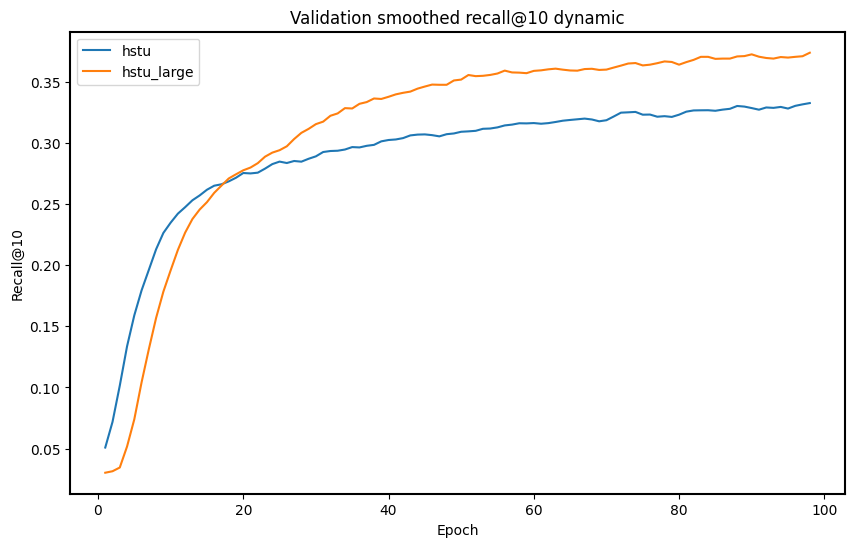

,recall@10,ndcg@10,recall@50,ndcg@50,recall@200,ndcg@200,coverage@10,serendipity@10
model,,,,,,,,
hstu,0.322682,0.187915,0.589404,0.247056,0.785762,0.276861,0.650378,0.002877
hstu_large,0.364238,0.216433,0.619371,0.273545,0.803146,0.301466,0.684665,0.003299


In [14]:
pivot_table = get_results(pivot_name,metrics_to_show, show_loss=False)
pivot_table

#### MovieLens-20M

In [ ]:
%%time
!wget -q https://files.grouplens.org/datasets/movielens/ml-20m.zip -O ml-20m.zip
!unzip -o ml-20m.zip
!rm ml-20m.zip

In [14]:
config_ml_20m  = config.copy()
config_ml_20m["n_factors"] = 256
config_ml_20m["n_heads"] = 4
config_ml_20m["n_blocks"] = 4

In [ ]:
hstu  = HSTUModel(
    relative_time_attention=True,
    relative_pos_attention=True,
    **config_ml_20m
)
models = {
    "hstu": hstu,
}

In [ ]:
seed_everything(RANDOM_STATE, workers=True)
dataset_name = "ml-20m"
pivot_name = f"pivot_results_{dataset_name}.json"
ml_df = get_movielens_df(dataset_name)
dataset = Dataset.construct(ml_df)

In [ ]:
evaluate(models,loo_splitter,dataset,pivot_name)

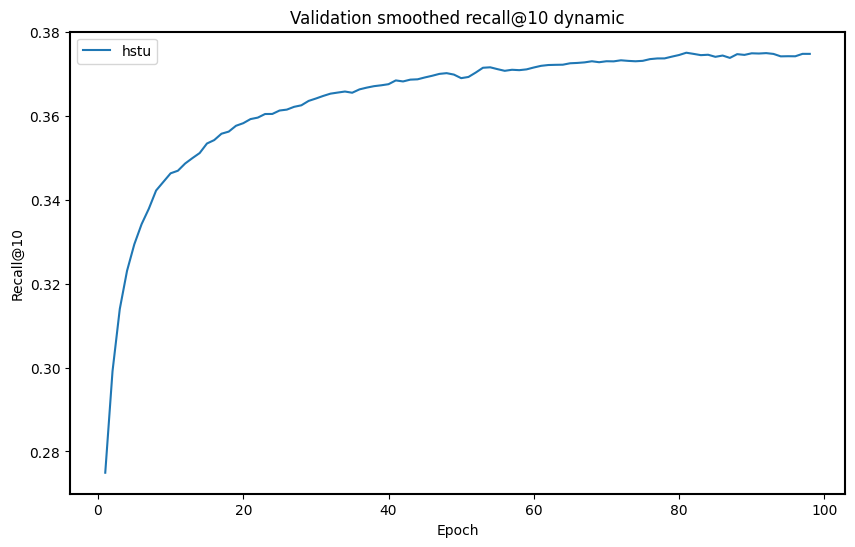

,recall@10,ndcg@10,recall@50,ndcg@50,recall@200,ndcg@200,coverage@10,serendipity@10
model,,,,,,,,
hstu,0.344053,0.206557,0.600211,0.26321,0.800799,0.293759,0.317295,0.000837


In [13]:
pivot_table = get_results(pivot_name,metrics_to_show, show_loss=False)
pivot_table

## Ablation study for Relative Attention Bias

RecTools implementation of HSTU allows to include different variants of rab (Relative Attention Bias) for the model with simple flags. We test the quality of different variant below. And we also include SASRec for comparison.

Please note that HSTU provides time-aware recommendations only when `relative_time_attention` is set to ``True``.



In [ ]:
seed_everything(RANDOM_STATE, workers=True)
dataset_name = "ml-1m"
pivot_name = f"pivot_results_ablation_{dataset_name}.json"
ml_df = get_movielens_df(dataset_name)
dataset = Dataset.construct(ml_df)

In [ ]:
hstu  = HSTUModel(
    relative_time_attention=True,
    relative_pos_attention=True,
    **config
)
hstu_rab_p  = HSTUModel(
    relative_time_attention=False,
    relative_pos_attention=True,
    **config
)
hstu_rab_t  = HSTUModel(
    relative_time_attention=True,
    relative_pos_attention=False,
    **config
)
hstu_no_rab  = HSTUModel(
    relative_time_attention=False,
    relative_pos_attention=False,
    **config
)
sasrec = SASRecModel(
    **config
)
models = {
    "hstu": hstu,
    "hstu_rab_t": hstu_rab_t,
    "hstu_rab_p": hstu_rab_p,
    "hstu_no_rab": hstu_no_rab,
    "sasrec": sasrec,
}

In [ ]:
evaluate(models,loo_splitter,dataset,pivot_name)

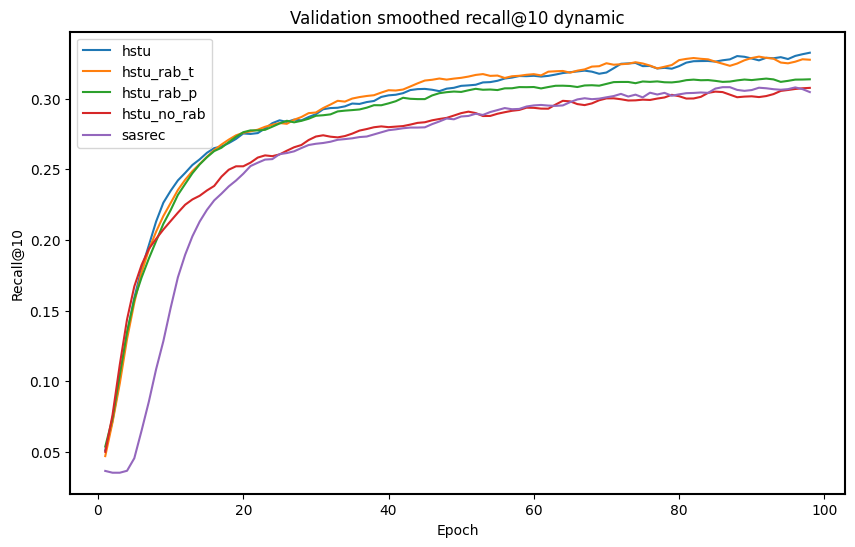

,recall@10,ndcg@10,recall@50,ndcg@50,recall@200,ndcg@200,coverage@10,serendipity@10
model,,,,,,,,
hstu,0.322682,0.187915,0.589404,0.247056,0.785762,0.276861,0.650378,0.002877
hstu_rab_t,0.320530,0.186459,0.584106,0.244937,0.784934,0.275469,0.659017,0.002862
hstu_rab_p,0.302318,0.171828,0.570199,0.231111,0.772020,0.261827,0.644438,0.002659
hstu_no_rab,0.298013,0.168559,0.559934,0.226351,0.766060,0.257793,0.618251,0.002535
sasrec,0.287748,0.162196,0.551821,0.220394,0.763245,0.252509,0.660367,0.002623


In [19]:
pivot_table = get_results(pivot_name,metrics_to_show, show_loss=False)
pivot_table

### Context-aware recommendations for HSTU model

Since relative time attention utilizes the difference in timestamps between the target item and the last item in user interactions, it is necessary to feed target timestamps information to model when calling `recommend`.

Since timestamps are just one specific form of context that can be used by recommender models during inference, we accept the optional `context` argument in `recommend` method for our models.

`context` is just a pandas dataframe. In case of HSTU it should have columns "user_id" (`Columns.User`) and "datetime" (`Columns.Datetime`).

In [20]:
from rectools.dataset.context import  get_context

users = [1,2,3] # users we are recommending for
query_time = max(ml_df[Columns.Datetime]) # for example
context_df = pd.DataFrame(
    {
        Columns.User: [1, 2, 3],
        Columns.Datetime: [query_time]*3,
    }
)
context = get_context(context_df) # context preprocessing. You can also just pass full test interactions df here if you have it

In [21]:
hstu.recommend(
    users=users,
    dataset=dataset,
    k=3,
    filter_viewed=True,
    context=context) # provide context

# Model processes context timestamp during inference:

,user_id,item_id,score,rank
0,1,2858,0.235928,1
1,1,589,0.229704,2
2,1,593,0.224703,3
3,2,1,0.254660,1
4,2,919,0.235681,2
5,2,260,0.218732,3
6,3,1,0.328947,1
7,3,2716,0.325233,2
8,3,2174,0.316063,3


To check if model requires context, there is a `require_recommend_context` attribute of each model:

In [24]:
hstu.require_recommend_context, hstu_rab_p.require_recommend_context

(True, False)

When context is required but not provided, `recommend` method will raise an error:

In [25]:
hstu.recommend(
    users=users,
    dataset=dataset,
    k=3,
    filter_viewed=True,
    context=None)

ValueError: This model requires `context` to be provided for recommendations generation (model.require_recommend_context is True).Check docs and examples for details.